# Eurovision 2022 (Draft Notebook)


## Potential Research Questions

1. Are Jury Voters less affected by Cultural Influences in Eurovision ?
    * How can we characterize the influence of culture in voting?


## Plan

### 1. Pre-Analysis or Exploratory Data Analysis

Worth doing again, with newer data.

1. Basically, redo figure 7 from the paper with the newest data

## 2. Agent-Based Models

1. Null Model
2. Model 1
3. Cultural Affinity Model
   a. Cultural Affinity Model part 2


## 3. Find Best Fit

1. Kolmogorov-Smirnov test
2. Hypothesis: Simulated and Empirical FoF come from the same distribution.
    3. This was rejected in the original paper
    
    
### Further Work
1. Consider doing section 5
2. Ambitious: Section 6


Suggestion: Focus on the ABMs as opposed to fully recreating the full paper (K-S tests etc.) 
Also try various things:  subsets of networks.  what happens if you take away a node etc etc.  Give extra weight to Ukraine itself?

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
from mesa import Model, Agent
from mesa.time import RandomActivation
#import pyvis.network as pyvisnetwork
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector


from scipy.stats import rankdata
from scipy.stats import ks_2samp

In [2]:
YEARS_TO_CONSIDER = [2016, 2017, 2018, 2019, 2021, 2022]

# 1. Exploratory Data Analysis

First, we load the data for the various years and then visualize the network for a given year

In [3]:
#df = pd.read_excel('https://query.data.world/s/cuokq5sbbqlogvjrdwdeacvp367xnq')
df = pd.read_csv("data/dataworld.csv")
df

,Unnamed: 0.1,Unnamed: 0,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,0,0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1,1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,2,2,1975,f,1975f,J,Belgium,France,2,NaN
3,3,3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,4,4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


In [4]:
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns={
    "(semi-) final": "semi_or_final",
    "Jury or Televoting": "jury_or_televoting",
    "From country": "from",
    "To country": "to",
    "Points": "points"
}, inplace=True)

In [5]:
df_finals = df[df["semi_or_final"] == 'f']
df_finals_televoting = df_finals[df_finals["jury_or_televoting"] == "T"]
df_finals_jury = df_finals[df_finals["jury_or_televoting"] == "J"]


display(df_finals_televoting)
display(df_finals_jury)

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
36352,36352,36352,2016,f,2016f,T,Albania,Armenia,2,NaN
36353,36353,36353,2016,f,2016f,T,Albania,Australia,12,NaN
36354,36354,36354,2016,f,2016f,T,Albania,Austria,0,NaN
36355,36355,36355,2016,f,2016f,T,Albania,Azerbaijan,0,NaN
36356,36356,36356,2016,f,2016f,T,Albania,Belgium,0,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
0,0,0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1,1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,2,2,1975,f,1975f,J,Belgium,France,2,NaN
3,3,3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,4,4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...,...,...
56283,56283,56283,2022,f,2022f,J,United Kingdom,Serbia,1,NaN
56284,56284,56284,2022,f,2022f,J,United Kingdom,Spain,10,NaN
56285,56285,56285,2022,f,2022f,J,United Kingdom,Sweden,12,NaN
56286,56286,56286,2022,f,2022f,J,United Kingdom,Switzerland,2,NaN


Let's visualize!

# Agent Based Modelling

In [6]:
SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])

In [7]:
def calc_All_FoF(df, from_country, points_column = "points", FoF_column = "FoF"):
    Voter_selector = df["from"] == from_country

    voting_countries_2022 = df["from"].unique()


    N = len(voting_countries_2022)
    
    for to_country in df["to"].unique():
        Candidate_selector = df["to"] == to_country

        final_score = sum(df.loc[Candidate_selector, points_column])

        points = df.loc[Voter_selector & Candidate_selector, points_column]

        df.loc[Voter_selector & Candidate_selector, FoF_column ] =  ( points / 12 ) - ( ( final_score - points )/( 12*(N-2) ) )

## Null Model

In this null model, countries freely vote for other countries.  The only restriction is that they can assign only a fixed amount of points

In [8]:
class NullVotingAgent(Agent):
    
    def __init__(self, unique_id, model, df):
        '''
         Create a new Null Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        
        self.df = df
        
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        #print(f"Country {self.unique_id} is now voting")
        
        country_row_selector = self.df["from"] == self.unique_id

        fit = np.random.uniform(0, 1, size=len( self.df[country_row_selector] ))

        points_given = 58 * (fit/sum(fit))
        
        #print(f"{voting_country=}, {points_given=}")
        self.df.loc[country_row_selector, "null_model_points"] += points_given

In [9]:
def get_null_model_ks(model):
    
    data1 = model.df["FoF"]
    data2 = model.df["null_model_FoF"]
    
    return ks_2samp(data1, data2).statistic

def get_model_df(model):
    return model.df

class NullVotingModel(Model):
    
    def __init__(self, jury_or_televoting, year):
        '''
        Create a new NullVotingModel model.

         Args:
            jury_or_televoting: a string with values  
                * J: Jury
                * T: Televoting
            year: year of competition
        '''
        
        super().__init__()
        
        df_finals_type = df_finals[df_finals["jury_or_televoting"] == jury_or_televoting]
        df_finals_televoting_year = df_finals_type[df_finals_type["Year"]==year].copy()

        self.df = df_finals_televoting_year
        
        self.datacollector = DataCollector(
            model_reporters={
                "ks_statistic": get_null_model_ks,
                "df": get_model_df
            }
        )
        
        self.schedule = RandomActivation(self)
        
        
        self.df["null_model_points"] = 0
        self.df["FoF"] = 0
        self.df["null_model_FoF"] = 0

        voting_countries = self.df["from"].unique()

        for voting_country in voting_countries:
            country_row_selector = self.df["from"] == voting_country
            the_agent = NullVotingAgent(voting_country, self, self.df)
            self.schedule.add(the_agent)
            

    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        
        
        self.schedule.step()
        
        #print("Going to start calc all the FoF")
        for voting_country in self.df["from"].unique():
            calc_All_FoF(self.df, voting_country, 'points', "FoF")        
            calc_All_FoF(self.df, voting_country, 'null_model_points', "null_model_FoF")
            
        self.datacollector.collect(self)

## Model1 ABM
This model also gives points at random, but follows the rules of the contest

In [10]:
class Model1Agent(Agent):
    
    def __init__(self, unique_id, model, df):
        '''
         Create a new Model 1 Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        self.df = df
        
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        country_row_selector = self.df["from"] == self.unique_id

        fit = pd.Series( np.random.uniform(0, 1, size=len(self.df[country_row_selector])) )
        rank = fit.rank(ascending=False)
        points_given = rank.apply(
            lambda x: SCORES[int(x) - 1] if x <= 10 else 0
        )
        
        #print(f"{rank=}, {voting_country=}, {type(points_given)=}")
        self.df.loc[country_row_selector, "model1_points"] += points_given.to_numpy()

In [11]:
def get_model1_ks(model):
    
    data1 = model.df["FoF"]
    data2 = model.df["model1_FoF"]
    
    return ks_2samp(data1, data2).statistic

class Model1Model(Model):
    
    def __init__(self, jury_or_televoting, year):
        '''
        Create a new NullVotingModel model.

         Args:
            jury_or_televoting: a string with values  
                * J: Jury
                * T: Televoting
            year: year of competition
        '''
        
        super().__init__()
        
        df_finals_type = df_finals[df_finals["jury_or_televoting"] == jury_or_televoting]
        df_finals_televoting_year = df_finals_type[df_finals_type["Year"]==year].copy()

        self.df = df_finals_televoting_year
        
        self.datacollector = DataCollector(
            model_reporters={
                "ks_statistic": get_model1_ks,
                "df": get_model_df
            }
        )
        
        self.df["model1_points"] = 0
        
        self.schedule = RandomActivation(self)
        

        voting_countries = self.df["from"].unique()

        for voting_country in voting_countries:
            country_row_selector = self.df["from"] == voting_country
            a = Model1Agent(voting_country, self, self.df)
            self.schedule.add(a)
            

    def step(self):
        '''
        Run one step of the model.
        '''
        
        self.schedule.step()
        
        #print("Going to start calc all the FoF")
        for voting_country in self.df["from"].unique():
            calc_All_FoF(self.df, voting_country, 'points', "FoF")        
            calc_All_FoF(self.df, voting_country, 'model1_points', "model1_FoF")
            
        self.datacollector.collect(self)

## Affinity Model

In [12]:
class AffinityModelAgent(Agent):
    
    def __init__(self, unique_id, model, df, alpha, cultural_network):
        '''
         Create a new Model 1 Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        
        self.df = df
        self.cultural_network = cultural_network
        self.alpha = alpha
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        country_row_selector = self.df["from"] == self.unique_id
        
        def affinity_fit(row):
            '''
                row: a dataframe row
            '''
            q = float(self.df["relative_score"].sample(1))

            from_country = row['from']
            to_country = row['to']


            network_part = nx.get_edge_attributes(self.cultural_network, "weight")[(from_country, to_country)]

            the_fit = self.alpha * q + network_part * (1 - self.alpha)

            return the_fit

        
        country_df = self.df[country_row_selector]

        fit = country_df.apply(
            lambda row: affinity_fit(row), axis=1
        )
        #print(f"{self.unique_id=}, {fit=}")
        rank = fit.rank(ascending=False)
        points_given = rank.apply(
            lambda x: SCORES[int(x) - 1] if x <= 10 else 0
        )
        
        self.df.loc[country_row_selector, "affinity_model_points"] += points_given.to_numpy()


In [13]:
def get_affinity_ks(model):
    
    data1 = model.df["FoF"]
    data2 = model.df["affinity_model_FoF"]
    
    return ks_2samp(data1, data2).statistic

def get_affinity_nw(model):
    
    return model.cultural_network

class AffinityModel(Model):
    
    def __init__(self,jury_or_televoting, year, mu, sigma, alpha):
        '''
        Create a new NullVotingModel model.

         Args:
        '''
        
        super().__init__()
        
        self.datacollector = DataCollector(
            model_reporters={
                "ks_statistic": get_affinity_ks,
                "df": get_model_df,
                "nw": get_affinity_nw
            }
        )

        
        df_finals_type = df_finals[df_finals["jury_or_televoting"] == jury_or_televoting]
        df_finals_televoting_year = df_finals_type[df_finals_type["Year"]==year].copy()
        self.df = df_finals_televoting_year
        
        self.df["affinity_model_points"] = 0
        
        for to_country in df["to"].unique():
            Candidate_selector = self.df["to"] == to_country
        
            candidate_points = sum(self.df.loc[Candidate_selector, "points"])

            self.df.loc[ Candidate_selector, "relative_score" ] = candidate_points/sum(self.df["points"])
        
        
        self.cultural_network = nx.from_pandas_edgelist(
            self.df,
            source="from",
            target="to",
            create_using=nx.DiGraph()
        )

        self.mu = mu
        self.sigma = sigma
        self.alpha = alpha

        dict_weight = {}
        for edge in self.cultural_network.edges():
            sampled_weight = np.random.normal(mu, sigma)
            dict_weight[edge] = sampled_weight
        nx.set_edge_attributes(self.cultural_network, values = dict_weight, name = 'weight')
        
        

        voting_countries = self.df["from"].unique()
        
        self.schedule = RandomActivation(self)

        for voting_country in voting_countries:
            a = AffinityModelAgent(voting_country, self, self.df, self.alpha, self.cultural_network)
            self.schedule.add(a)
            

    def step(self):
        '''
        Run one step of the model.
        '''
        
        self.schedule.step()
        
        #print("Going to start calc all the FoF")
        for voting_country in self.df["from"].unique():
            calc_All_FoF(self.df, voting_country, 'points', "FoF")        
            calc_All_FoF(self.df, voting_country, 'affinity_model_points', "affinity_model_FoF")
            
        self.datacollector.collect(self)

# 3. Run the ABMs in a batch for various years



# 4. Friend-Or-Foe for the ABMS

Now that we have Various models and also empirical data, we can calculate the Friend-or-Foe coefficients for each of them

## Batch Run

In [14]:
params_null = {
    "jury_or_televoting": ["T", "J"],
    "year": YEARS_TO_CONSIDER    # 2020 Contest was cancelled due to COVID-19
}

In [15]:
from mesa.batchrunner import batch_run

results_null = batch_run(
    NullVotingModel,
    parameters=params_null,
    iterations=10,
    max_steps=1,
    number_processes=None,
    data_collection_period=-1,
    display_progress=True,
)

120it [01:00,  1.99it/s]


In [16]:
res_null = pd.DataFrame(results_null)
res_null.to_csv("res_null.csv")

In [17]:
res_null = pd.read_csv("res_null.csv")
display(res_null.head())

,Unnamed: 0,RunId,iteration,Step,jury_or_televoting,year,ks_statistic,df
0,0,0,0,1,T,2021,0.250000,Unnamed: 0.1 Unnamed: 0 Year semi_or_...
1,1,1,0,1,J,2022,0.206154,Unnamed: 0.1 Unnamed: 0 Year semi_or_...
2,2,2,0,1,J,2021,0.202429,Unnamed: 0.1 Unnamed: 0 Year semi_or_...
3,3,3,0,1,T,2022,0.197949,Unnamed: 0.1 Unnamed: 0 Year semi_or_...
4,4,4,0,1,T,2019,0.229367,Unnamed: 0.1 Unnamed: 0 Year semi_or_...


In [18]:
#results_null[20]["df"]

In [19]:
params_model1 = {
    "jury_or_televoting":  ["T", "J"],
    "year": YEARS_TO_CONSIDER    # 2020 Contest was cancelled due to COVID-19
}

In [20]:
from mesa.batchrunner import batch_run

results_model1 = batch_run(
    Model1Model,
    parameters=params_model1,
    iterations=1,
    max_steps=1,
    number_processes=None,
    data_collection_period=-1,
    display_progress=True,
)

12it [00:06,  1.74it/s]


In [21]:
res_model1 = pd.DataFrame(results_model1)
res_model1.to_csv("res_model1.csv")

In [22]:
res_model1 = pd.read_csv("res_model1.csv")
display(res_model1.head())

,Unnamed: 0,RunId,iteration,Step,jury_or_televoting,year,ks_statistic,df
0,0,0,0,1,J,2019,0.332054,Unnamed: 0.1 Unnamed: 0 Year semi_or_...
1,1,1,0,1,J,2017,0.352564,Unnamed: 0.1 Unnamed: 0 Year semi_or_...
2,2,2,0,1,T,2019,0.367562,Unnamed: 0.1 Unnamed: 0 Year semi_or_...
3,3,3,0,1,J,2016,0.356473,Unnamed: 0.1 Unnamed: 0 Year semi_or_...
4,4,4,0,1,J,2022,0.309744,Unnamed: 0.1 Unnamed: 0 Year semi_or_...


In [23]:
params_affinity = {
    "jury_or_televoting":  ["T", "J"],
    "year": YEARS_TO_CONSIDER,    # 2020 Contest was cancelled due to COVID-19
    "mu": np.linspace(-10, 10, 6),
    "sigma": np.linspace(0, 5, 6),
    "alpha": np.linspace(0.1, 0.9, 5)
} 

In [24]:
from mesa.batchrunner import batch_run

results_affinity = batch_run(
    AffinityModel,
    parameters=params_affinity,
    iterations=1,
    max_steps=1,
    number_processes=None,
    data_collection_period=-1,
    display_progress=True,
)

2160it [28:23,  1.27it/s]


In [25]:
the_df = results_affinity[319]["df"]




#Candidate_selector = the_df["to"] == "Australia"
#
#final_score = sum(the_df.loc[Candidate_selector, "points"])
#
#candidate_points = sum(the_df.loc[Candidate_selector, "points"])
#
#the_df.loc[ Candidate_selector, "relative_score" ] = candidate_points/sum(the_df["points"])
#
the_df[the_df["to"] == "Ukraine"]

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,affinity_model_points,relative_score,FoF,affinity_model_FoF
39974,39974,39974,2017,f,2017f,T,Albania,Ukraine,0,NaN,0,0.009852,-0.050000,-0.358333
40000,40000,40000,2017,f,2017f,T,Armenia,Ukraine,0,NaN,12,0.009852,-0.050000,0.666667
40026,40026,40026,2017,f,2017f,T,Australia,Ukraine,0,NaN,5,0.009852,-0.050000,0.068750
40052,40052,40052,2017,f,2017f,T,Austria,Ukraine,0,NaN,5,0.009852,-0.050000,0.068750
40078,40078,40078,2017,f,2017f,T,Azerbaijan,Ukraine,0,NaN,0,0.009852,-0.050000,-0.358333
40104,40104,40104,2017,f,2017f,T,Belarus,Ukraine,1,NaN,11,0.009852,0.035417,0.581250
40130,40130,40130,2017,f,2017f,T,Belgium,Ukraine,0,NaN,0,0.009852,-0.050000,-0.358333
40156,40156,40156,2017,f,2017f,T,Bulgaria,Ukraine,0,NaN,12,0.009852,-0.050000,0.666667
40182,40182,40182,2017,f,2017f,T,Croatia,Ukraine,0,NaN,11,0.009852,-0.050000,0.581250
40208,40208,40208,2017,f,2017f,T,Cyprus,Ukraine,0,NaN,0,0.009852,-0.050000,-0.358333


In [26]:
the_df2 = results_model1[0]["df"]




#Candidate_selector = the_df["to"] == "Australia"
#
#final_score = sum(the_df.loc[Candidate_selector, "points"])
#
#candidate_points = sum(the_df.loc[Candidate_selector, "points"])
#
#the_df.loc[ Candidate_selector, "relative_score" ] = candidate_points/sum(the_df["points"])
#
the_df2[the_df2["to"] == "Ukraine"]

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,model1_points,FoF,model1_FoF


In [27]:
res_affinity = pd.DataFrame(results_affinity)
res_affinity.to_csv("res_affinity.csv")

In [28]:
res_affinity = pd.read_csv("res_affinity.csv")

In [29]:
display(res_affinity.head())

,Unnamed: 0,RunId,iteration,Step,jury_or_televoting,year,mu,sigma,alpha,ks_statistic,df,nw
0,0,0,0,1,T,2016,-10.0,0.0,0.7,0.357411,Unnamed: 0.1 Unnamed: 0 Year semi_or_...,DiGraph with 42 nodes and 1066 edges
1,1,1,0,1,T,2016,-10.0,0.0,0.1,0.361163,Unnamed: 0.1 Unnamed: 0 Year semi_or_...,DiGraph with 42 nodes and 1066 edges
2,2,2,0,1,T,2016,-10.0,1.0,0.5,0.529081,Unnamed: 0.1 Unnamed: 0 Year semi_or_...,DiGraph with 42 nodes and 1066 edges
3,3,3,0,1,T,2016,-10.0,1.0,0.9,0.503752,Unnamed: 0.1 Unnamed: 0 Year semi_or_...,DiGraph with 42 nodes and 1066 edges
4,4,4,0,1,T,2016,-10.0,0.0,0.9,0.350844,Unnamed: 0.1 Unnamed: 0 Year semi_or_...,DiGraph with 42 nodes and 1066 edges


In [30]:
results_affinity[0]

{'RunId': 0,
 'iteration': 0,
 'Step': 1,
 'jury_or_televoting': 'T',
 'year': 2016,
 'mu': -10.0,
 'sigma': 0.0,
 'alpha': 0.7000000000000001,
 'ks_statistic': 0.3574108818011257,
 'df':        Unnamed: 0.1  Unnamed: 0  Year semi_or_final Edition  \
 36352         36352       36352  2016             f   2016f   
 36353         36353       36353  2016             f   2016f   
 36354         36354       36354  2016             f   2016f   
 36355         36355       36355  2016             f   2016f   
 36356         36356       36356  2016             f   2016f   
 ...             ...         ...   ...           ...     ...   
 37413         37413       37413  2016             f   2016f   
 37414         37414       37414  2016             f   2016f   
 37415         37415       37415  2016             f   2016f   
 37416         37416       37416  2016             f   2016f   
 37417         37417       37417  2016             f   2016f   
 
       jury_or_televoting            from  

In [31]:

best_affinity_model = AffinityModel(
    jury_or_televoting="T", 
    year=2016, 
    mu=-0.5, 
    sigma=0.0, 
    alpha=0.1
)


best_affinity_model.step()


    
data1 = best_affinity_model.df["FoF"]
data2 = best_affinity_model.df["affinity_model_FoF"]

ks_2samp(data1, data2).statistic

#ax = best_affinity_model.df[["FoF", "affinity_model_FoF"]].plot.kde()


0.3621013133208255

Plotting empirical and best Model FoF's

Affinity Model | jury_or_tele='T' the_year=2016 the_mu=6.0 the_sigma=0.0 the_alpha=0.7000000000000001
Affinity Model | jury_or_tele='J' the_year=2016 the_mu=-10.0 the_sigma=0.0 the_alpha=0.9
Affinity Model | jury_or_tele='T' the_year=2017 the_mu=-2.0 the_sigma=0.0 the_alpha=0.1
Affinity Model | jury_or_tele='J' the_year=2017 the_mu=6.0 the_sigma=0.0 the_alpha=0.7000000000000001
Affinity Model | jury_or_tele='T' the_year=2018 the_mu=-6.0 the_sigma=0.0 the_alpha=0.7000000000000001
Affinity Model | jury_or_tele='J' the_year=2018 the_mu=2.0 the_sigma=0.0 the_alpha=0.7000000000000001
Affinity Model | jury_or_tele='T' the_year=2019 the_mu=-2.0 the_sigma=0.0 the_alpha=0.3
Affinity Model | jury_or_tele='J' the_year=2019 the_mu=2.0 the_sigma=0.0 the_alpha=0.9
Affinity Model | jury_or_tele='T' the_year=2021 the_mu=-10.0 the_sigma=0.0 the_alpha=0.3
Affinity Model | jury_or_tele='J' the_year=2021 the_mu=2.0 the_sigma=0.0 the_alpha=0.5
Affinity Model | jury_or_tele='T' the_year=2022 the_mu=-2.0 the

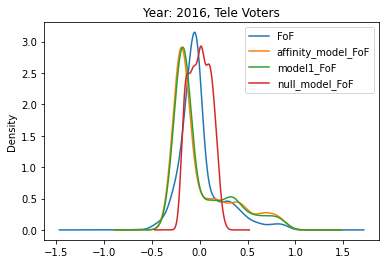

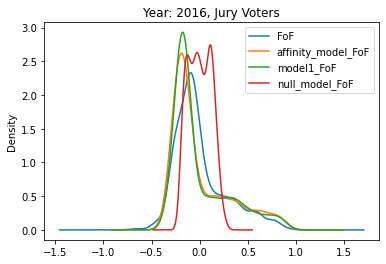

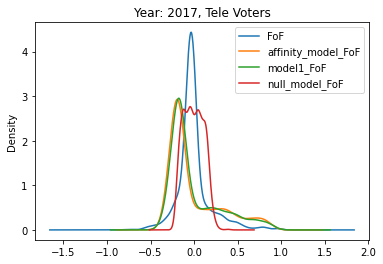

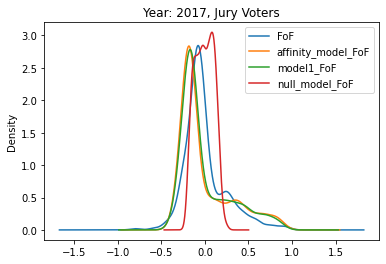

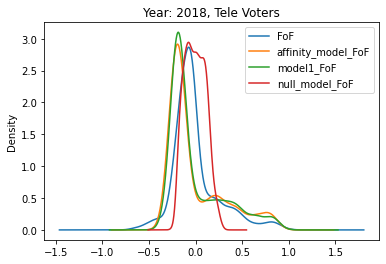

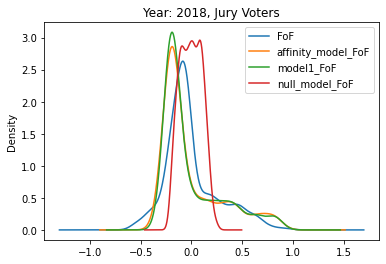

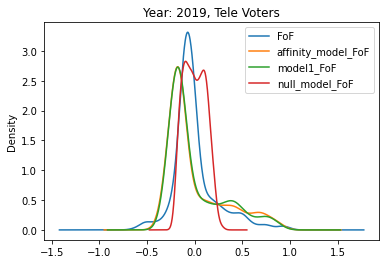

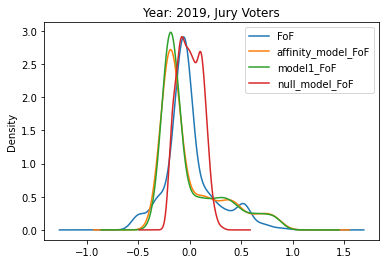

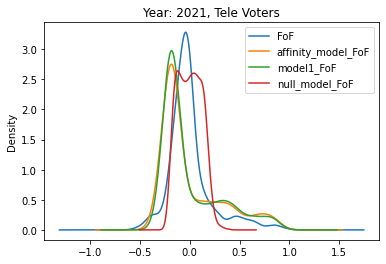

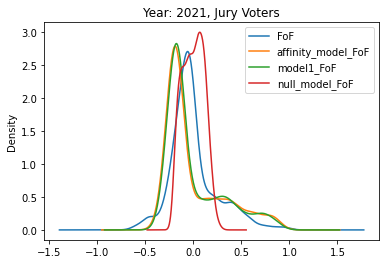

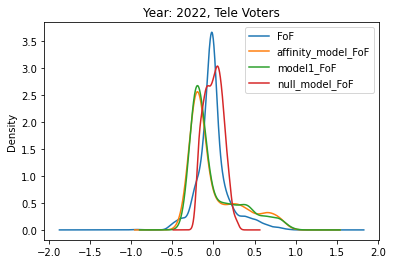

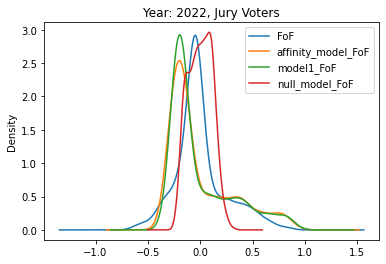

In [32]:
def plot_best_affinity_model(jury_or_tele, the_year):
    
    df_affinity_year_type = res_affinity[
        (res_affinity["year"] == the_year) & 
        (res_affinity["jury_or_televoting"] == jury_or_tele)
    ]
    kses_year_type = df_affinity_year_type["ks_statistic"]
    
    the_mu = df_affinity_year_type.loc[kses_year_type.idxmin()]["mu"]
    the_sigma = df_affinity_year_type.loc[kses_year_type.idxmin()]["sigma"]
    the_alpha = df_affinity_year_type.loc[kses_year_type.idxmin()]["alpha"]
    
    
    print(f"Affinity Model | {jury_or_tele=} {the_year=} {the_mu=} {the_sigma=} {the_alpha=}")
    best_affinity_model = AffinityModel(
        jury_or_televoting=jury_or_tele, 
        year=the_year, 
        mu=the_mu, 
        sigma=the_sigma, 
        alpha=the_alpha
    )

    voter_type = "Jury Voters" if jury_or_tele == "J" else "Tele Voters"

    best_affinity_model.step()
    ax = best_affinity_model.df[["FoF", "affinity_model_FoF"]].plot.kde(title=f"Year: {the_year}, {voter_type}")
    
    
    best_model1_model = Model1Model(jury_or_televoting=jury_or_tele, year=the_year)
    best_model1_model.step()
    best_model1_model.df[["model1_FoF"]].plot.kde(ax=ax)
    
    
    best_null_model = NullVotingModel(jury_or_televoting=jury_or_tele, year=the_year)

    best_null_model.step()
    best_null_model.df[["null_model_FoF"]].plot.kde(ax=ax)
    
    
    
    

plot_best_affinity_model("T", 2016)
plot_best_affinity_model("J", 2016)


plot_best_affinity_model("T", 2017)
plot_best_affinity_model("J", 2017)


plot_best_affinity_model("T", 2018)
plot_best_affinity_model("J", 2018)


plot_best_affinity_model("T", 2019)
plot_best_affinity_model("J", 2019)


plot_best_affinity_model("T", 2021)
plot_best_affinity_model("J", 2021)


plot_best_affinity_model("T", 2022)
plot_best_affinity_model("J", 2022)

## Influence of Culture over time

Low Alpha => Higher Influence of Culture

<ipython-input-33-5dfa18b53f09>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-33-5dfa18b53f09>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-33-5dfa18b53f09>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-33-5dfa18b53f09>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-33-5dfa18b53f09>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

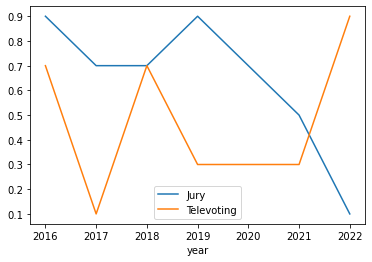

In [33]:
df = pd.DataFrame(columns=["year", "j_or_t", "alpha"])

for the_year in YEARS_TO_CONSIDER:
    for jury_or_tele in ["J", "T"]:
        df_affinity_year_type = res_affinity[
            (res_affinity["year"] == the_year) & 
            (res_affinity["jury_or_televoting"] == jury_or_tele)
        ]
        kses_year_type = df_affinity_year_type["ks_statistic"]

        the_mu = df_affinity_year_type.loc[kses_year_type.idxmin()]["mu"]
        the_sigma = df_affinity_year_type.loc[kses_year_type.idxmin()]["sigma"]
        the_alpha = df_affinity_year_type.loc[kses_year_type.idxmin()]["alpha"]

        new_row = {'year':the_year, 'j_or_t':jury_or_tele, 'alpha': the_alpha}
        df = df.append(new_row, ignore_index=True)

fig, ax = plt.subplots()
df.groupby('j_or_t').plot(x='year', y='alpha', ax=ax)
ax.legend(["Jury", "Televoting"])
